# Confidence Interval
In this notebook we try to build a confidence interval around our predictions using the methods and functions shown here:
https://gist.github.com/roncho12/60178f12ea4c3a74764fd645c6f2fe13

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm


from sklearn.metrics import  roc_auc_score

import xgboost as xgb

from imblearn.over_sampling import SMOTE


%matplotlib inline

Using TensorFlow backend.


# 1.0 Load Data

## 1.1 Training Data

In [2]:
#get directory
df_train_path = os.path.join('data','df_train_scaled.csv')
df_test_path = os.path.join('data','df_test_scaled.csv')

In [3]:
df_train = pd.read_csv(df_train_path, compression='zip',index_col=0)
df_train.head()

/Users/nadimkawwa/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,pub_rec,grade,purp_renewable_energy,revol_bal,open_acc,mort_acc,purp_credit_card,purp_car,e_exec,verification_status,...,installment,total_acc,e_admin,purp_medical,purp_vacation,e_self,purp_debt_consolidation,int_rate,annual_inc,purp_home_improvement
2139270,0.0,-1.817008,0,-0.508426,-0.843970,-0.718077,0,0,0,0,...,-0.788166,-1.415080,0,0,0,0,1,0.190831,-1.073069,0
2139245,0.0,-2.586479,0,-0.549872,0.075527,-0.718077,0,0,0,0,...,-1.440208,-0.980748,0,0,0,0,1,0.653814,-0.507501,0
2139236,0.0,1.260876,0,-0.559592,-0.292272,-0.718077,0,0,0,0,...,-1.099830,-0.720149,0,0,0,0,1,-1.133175,0.855853,0
2139235,0.0,-0.278066,0,-0.594821,0.995025,-0.718077,0,0,0,0,...,-1.365033,-0.546417,0,0,0,0,0,-0.536115,-1.110524,0
2139225,0.0,1.260876,0,0.226401,0.627226,-0.718077,0,0,0,0,...,-0.870123,3.101968,0,0,0,0,0,-0.999098,1.324038,1


In [4]:
df_train.shape

(1292073, 43)

In [5]:
#target variable
target_col = 'loan_status'

#training variables
X_train = df_train.drop(columns=[target_col]).values
y_train = df_train[target_col].values


## 1.2 Test data

In [6]:
df_test = pd.read_csv(df_test_path, compression='zip',index_col=0)
df_test.head()

,pub_rec,grade,purp_renewable_energy,revol_bal,open_acc,mort_acc,purp_credit_card,purp_car,e_exec,verification_status,...,installment,total_acc,e_admin,purp_medical,purp_vacation,e_self,purp_debt_consolidation,int_rate,annual_inc,purp_home_improvement
244697,0.0,1.316121,0,-0.258040,-0.172649,-0.335020,0,0,0,2,...,2.819585,-0.001213,0,0,0,0,0,-1.237809,0.263661,0
244789,0.0,-0.236910,0,0.935375,2.552677,-0.335020,1,0,0,2,...,0.289097,1.790371,0,0,0,0,0,0.416115,0.411947,0
244459,0.0,-1.013426,0,-0.262623,-0.354337,0.730536,0,0,0,2,...,2.253124,0.243094,0,0,0,0,1,1.040837,-0.181633,0
245213,0.0,0.539606,0,-0.659508,-1.081091,0.197758,1,0,1,1,...,0.233329,-1.059876,0,0,0,0,0,-0.630029,-0.059664,0
245189,0.0,1.316121,0,-0.490607,-0.354337,-0.335020,0,0,0,0,...,-1.027633,-0.815569,0,0,0,0,0,-1.104394,0.902531,1


In [7]:
df_test.shape

(11534, 43)

In [8]:
X_test = df_test.drop(columns=[target_col]).values
y_test = df_test[target_col].values

# 2.0 Build Intervals

In [9]:
#instantiate smote
sm = SMOTE(random_state=42)

In [10]:
auc_arr = []

for _ in tqdm(range(200)):
    idx = np.random.choice(np.arange(len(X_train)), 100_000, replace=True)
    X_temp = X_train[idx]
    y_temp = y_train[idx]
    
    #apply oversampling to training data
    X_temp, y_temp = sm.fit_resample(X_temp, y_temp)
    
    #instantiate classifier
    clf = xgb.XGBClassifier(colsample_bytree=0.9, eta=0.3, max_depth=3)
    #fit to new data
    clf.fit(X_temp, y_temp)
    
    #predictions and scoring
    y_pred = clf.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    auc_arr.append(score)


100%|██████████| 200/200 [3:23:37<00:00, 61.09s/it]  


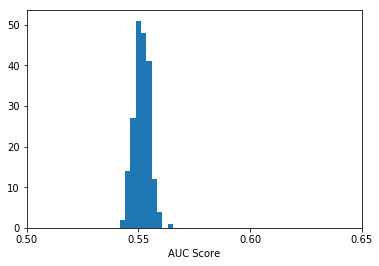

In [12]:
plt.hist(auc_arr)
plt.xlabel("AUC Score")
plt.xticks(np.arange(0.5, 0.65, 0.05))
plt.savefig(os.path.join("plots", 'auc_632_sampling.png'))
plt.show()